# Pollutants Analysis
The aim of this notebook is to select the required data regarding air pollution for the project. The notebook has the following structure.
* Data gathering, integration, and cleaning
* Data reduction and storage
* Data transformation
* Data selection
* Insights
Source: http://www.aire.cdmx.gob.mx/default.php?opc=%27aKBhnmI=%27&opcion=Zg==

The original files were not included in this GIT repository due to its large volume. They can be download
from the provided link (years from 2014-2016)

In [1]:
#Call libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from numpy import zeros

# Data gathering, integration, and cleaning
The raw data consists in three files: the main database with information of the different pollutant recorded by hour from 1985 to 2019 (one CSV file per year), a catalog to know the location about the stations that capture the data and a catalog to know the metric unit for each pollutant parameter. This section:
* Consolidate the different the main files into one data frame
* Integrate the catalog's data to the main data frame
* Selects the required columns for further work

In [2]:
#Display catalog of stations 
#The data frame has information about the station location in coordinates, city, and township
filen="../Resources/cat_estacion.csv"
stations_coor = pd.read_csv(filen, encoding="ISO-8859-1")
stations_coor.head()

,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station,Ciudad,Municipio
0,ACO,Acolman,-98.912003,19.635501,2198.0,NaN,4.840000e+11,Estado de Mexico,Valle de Mexico
1,AJU,Ajusco,-99.162611,19.154286,2942.0,NaN,4.840000e+11,Ciudad de Mexico,Tlalpan
2,AJM,Ajusco Medio,-99.207744,19.272161,2548.0,NaN,4.840000e+11,Ciudad de Mexico,Tlalpan
3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,4.840000e+11,Ciudad de Mexico,Gustavo A Madero
4,ATI,Atizapan,-99.254133,19.576963,2341.0,NaN,4.840000e+11,Estado de Mexico,Atizapan de Zaragoza


In [3]:
#Modify the catalog of stations to keep only relevant information for further analysis
#The catalog indicates in which city and township is located the station
stations_coor = stations_coor[["cve_estac","Ciudad","Municipio"]]
stations_coor.drop_duplicates(keep="first",inplace=True) 
stations_coor.head()

,cve_estac,Ciudad,Municipio
0,ACO,Estado de Mexico,Valle de Mexico
1,AJU,Ciudad de Mexico,Tlalpan
2,AJM,Ciudad de Mexico,Tlalpan
3,ARA,Ciudad de Mexico,Gustavo A Madero
4,ATI,Estado de Mexico,Atizapan de Zaragoza


In [4]:
#Call and display catalog of metrics 
data_file = "../Resources/cat_unidades.csv"
units = pd.read_csv(data_file, encoding="ISO-8859-1")
units.head()

,id_unidad,clave_unidad,nombre_unidad
0,1,ppb,partes por billón
1,2,µg/m³,microgramos por metro cúbico
2,3,m/s,metros por segundo
3,4,°,grados
4,5,°C,grados Celsius


In [5]:
#The main data is stored as multiple CSV by year. 
#This is useful because it is possible to call only those years of interest
#There is information stored from 1984 till 2019 

df = pd.DataFrame(columns=["date", "id_station", "id_parameter", "value", "unit"])
start=2014
end=2017
for y in range(start,end):
                    number_of_years= end-start
                    year_to_analyse = str(y)
                    filen="Contaminantes/contaminantes_"+year_to_analyse+".CSV"
                    print(filen)
                    reader = csv.reader(open(filen, "rt", encoding="ascii"), delimiter=",")
                    x = list(reader)
                    
                    #Due to the csv format, it is neccesary to remove the first 11 rows
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    x.pop(0)
                    df = df.append(pd.DataFrame(x, columns=["date", "id_station", "id_parameter", "value", "unit"]))

./Contaminantes/contaminantes_2014.CSV
./Contaminantes/contaminantes_2015.CSV
./Contaminantes/contaminantes_2016.CSV


In [6]:
#Get the length of the dataframe and display the first rows
df_len=len(df)
print(df_len)
#df.head()

5947680


In [7]:
#Check if there are duplicateds to drop
duplicates= pd.DataFrame({"Boolean":df.duplicated()})
duplicates2 = duplicates.loc[duplicates["Boolean"] == True,:]
len(duplicates2)

0

In [8]:
#Conditionals are used to identify the  unit id and its corresponding metric.
df.loc[df['unit'] =="15",'units_text'] = 'ppm'
df.loc[df['unit'] =="1",'units_text'] = 'ppb'
df.loc[df['unit'] =="2",'units_text'] = 'µg/m³'

#Conditionals are used to identify the station code id and its corresponding city and township
for index, row in stations_coor.iterrows():
    s_code = row['cve_estac']
    s_city = row['Ciudad']
    s_township = row['Municipio']
    df.loc[df['id_station'] ==s_code, 'City'] = s_city
    df.loc[df['id_station'] ==s_code, 'Township'] = s_township


df.head()

,date,id_station,id_parameter,value,unit,units_text,City,Township
0,01/01/2014 01:00,ACO,CO,0.3,15,ppm,Estado de Mexico,Valle de Mexico
1,01/01/2014 01:00,ACO,NO,,1,ppb,Estado de Mexico,Valle de Mexico
2,01/01/2014 01:00,ACO,NO2,,1,ppb,Estado de Mexico,Valle de Mexico
3,01/01/2014 01:00,ACO,NOX,,1,ppb,Estado de Mexico,Valle de Mexico
4,01/01/2014 01:00,ACO,O3,9,1,ppb,Estado de Mexico,Valle de Mexico


In [9]:
#Check the data type of each column. 
#It can be seen that the column "value" is an object and it is required as numeric 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5947680 entries, 0 to 2114087
Data columns (total 8 columns):
date            object
id_station      object
id_parameter    object
value           object
unit            object
units_text      object
City            object
Township        object
dtypes: object(8)
memory usage: 408.4+ MB


In [10]:
#convert the column "value" to numeric
df['value'] = pd.to_numeric(df['value'])

In [11]:
#Split the date and time and add it in different columns

#Time is split from the dat using a space
date_woh= df.date.str.split(' ').str[0].tolist()
time= df.date.str.split(' ').str[1].tolist()

df["date_woh"] = date_woh #can be used to pivot by day
df["time"] = time

#The date without hours is split using slash to get the day, month and year
day= df.date_woh.str.split('/').str[0].tolist()
month= df.date_woh.str.split('/').str[1].tolist()
year = df.date_woh.str.split('/').str[2].tolist()

df["day"] = day
df["month"] = month
df["year"] = year

#Another column is created joining the month and year to pivot by month
df["month_and_year"] = df['month'].astype(str) + " "+df['year'] #Month
df["date_woh"] = df['month'].astype(str) +" "+ df['day']
df["date_woh"] = df['date_woh'].astype(str) +" "+ df['year'] #day
df["date_w_h"] = df['date_woh'].astype(str) + " "+df['time'] #hour

df.head()

,date,id_station,id_parameter,value,unit,units_text,City,Township,date_woh,time,day,month,year,month_and_year,date_w_h
0,01/01/2014 01:00,ACO,CO,0.3,15,ppm,Estado de Mexico,Valle de Mexico,01 01 2014,01:00,01,01,2014,01 2014,01 01 2014 01:00
1,01/01/2014 01:00,ACO,NO,NaN,1,ppb,Estado de Mexico,Valle de Mexico,01 01 2014,01:00,01,01,2014,01 2014,01 01 2014 01:00
2,01/01/2014 01:00,ACO,NO2,NaN,1,ppb,Estado de Mexico,Valle de Mexico,01 01 2014,01:00,01,01,2014,01 2014,01 01 2014 01:00
3,01/01/2014 01:00,ACO,NOX,NaN,1,ppb,Estado de Mexico,Valle de Mexico,01 01 2014,01:00,01,01,2014,01 2014,01 01 2014 01:00
4,01/01/2014 01:00,ACO,O3,9.0,1,ppb,Estado de Mexico,Valle de Mexico,01 01 2014,01:00,01,01,2014,01 2014,01 01 2014 01:00


In [12]:
#Choose only the columns needed and reorder them into a more convenient order
df = df[["date","date_w_h","date_woh","month_and_year","year",\
         "id_station","City","Township","id_parameter","value","units_text"]]
df.tail()

,date,date_w_h,date_woh,month_and_year,year,id_station,City,Township,id_parameter,value,units_text
2114083,31/12/2016 24:00,12 31 2016 24:00,12 31 2016,12 2016,2016,INN,Estado de Mexico,Ocoyoacac,PM2.5,NaN,µg/m³
2114084,31/12/2016 24:00,12 31 2016 24:00,12 31 2016,12 2016,2016,INN,Estado de Mexico,Ocoyoacac,PMCO,NaN,µg/m³
2114085,31/12/2016 24:00,12 31 2016 24:00,12 31 2016,12 2016,2016,INN,Estado de Mexico,Ocoyoacac,SO2,1.0,ppb
2114086,31/12/2016 24:00,12 31 2016 24:00,12 31 2016,12 2016,2016,GAM,Ciudad de Mexico,Gustavo A Madero,O3,2.0,ppb
2114087,31/12/2016 24:00,12 31 2016 24:00,12 31 2016,12 2016,2016,GAM,Ciudad de Mexico,Gustavo A Madero,PM2.5,NaN,µg/m³


In [13]:
#Check for null values in the data frame
#Eventhough the raw data has several missing values
#The missing values are going to be handled after consolidating the data

null_count =df.isnull().sum(axis = 0)
print(null_count)
raw_df_missing_values= null_count["value"]
perct_of_total_df = raw_df_missing_values/df_len
print(f"The missing values represent the {perct_of_total_df} of the total dataframe")

date                    0
date_w_h                0
date_woh                0
month_and_year          0
year                    0
id_station              0
City                    0
Township                0
id_parameter            0
value             1241000
units_text              0
dtype: int64
The missing values represent the 0.20865278562397438 of the total dataframe


# Data  Reduction and main database storage
Consolidate all the stations data per municipality and then store it an a CSV file.

In [14]:
#Group the main database by municipality,date, parameter and units
gbd = df.groupby(['Township',"date_w_h","date_woh","month_and_year","year","id_parameter", "units_text"])
mean_by_township = pd.DataFrame(gbd.mean()).reset_index()
mean_by_township.head()

,Township,date_w_h,date_woh,month_and_year,year,id_parameter,units_text,value
0,Alvaro Obregon,01 01 2014 01:00,01 01 2014,01 2014,2014,CO,ppm,NaN
1,Alvaro Obregon,01 01 2014 01:00,01 01 2014,01 2014,2014,NO,ppb,NaN
2,Alvaro Obregon,01 01 2014 01:00,01 01 2014,01 2014,2014,NO2,ppb,NaN
3,Alvaro Obregon,01 01 2014 01:00,01 01 2014,01 2014,2014,NOX,ppb,NaN
4,Alvaro Obregon,01 01 2014 01:00,01 01 2014,01 2014,2014,O3,ppb,NaN


In [15]:
#Store data to compare it with the respiratory diseases in order to find some relationships
mean_by_township.to_csv("../Outputs/data_00_18.csv", encoding="ISO-8859-1", index=False, header=True)  

# Data  Transformation
To set down the limitations of the following analysis it is necessary to know what we have in order to know what can we do. To achieve this it is necessary to transform the structure of the data as follow:
* Divide by municipality
* Assign one column per pollutant
* Store all the data into a single variable

In [16]:
#Check for null values in after consolidating the raw data 
null_count =mean_by_township.isnull().sum(axis = 0)
print(null_count)
raw_mbd_missing_values= null_count["value"]
perct_of_total_df = raw_mbd_missing_values/len(mean_by_township)
print(f"The missing values after consolidating represent the {perct_of_total_df} of the total dataframe")

Township               0
date_w_h               0
date_woh               0
month_and_year         0
year                   0
id_parameter           0
units_text             0
value             739433
dtype: int64
The missing values after consolidating represent the 0.15932375106440927 of the total dataframe


In [17]:
#Create a dictionary to store a data frame per municipality. The key is the municipality name and the value 
#is the dataframe
stations_dict = {}
def df_for_Stations( station, dataframe ):
    town = mean_by_township["Township"] == station
    station_DF = mean_by_township.loc[town, :]
    return station_DF

#In this step we are also selecting only the municipalities belonging to Mexico City and discarting
#the municipalities belonging to "Estado de México"
stations =["Alvaro Obregon", "Azcapotzalco", "Benito Juarez", "Coyoacan",\
"Cuajimalpa de Morelos", "Cuauhtemoc", "Gustavo A Madero", "Iztacalco", "Iztapalapa", \
"Miguel Hidalgo", "Milpa Alta", "Tlalpan", "Venustiano Carranza", "Xochimilco"]

for station in stations:
    station_DF= df_for_Stations(station, mean_by_township)
    stations_dict[station] = station_DF  

In [18]:
#Unstack the pollutants parameters with pivot_table. For these four dictionaries are created
#one to store the data by hour, another one by day, the month and year 

stations_pivot_hour = {}
stations_pivot_day = {}
stations_pivot_month = {}
stations_pivot_year = {}

for station in stations:
    stations_pivot_hour[station] = stations_dict[station].pivot_table(index= 'date_w_h',\
                                                                      columns="id_parameter", values="value")
    stations_pivot_day[station] = stations_dict[station].pivot_table(index= 'date_woh',\
                                                                    columns="id_parameter", values="value")
    stations_pivot_month[station] = stations_dict[station].pivot_table(index= 'month_and_year',\
                                                                      columns="id_parameter", values="value")
    stations_pivot_year[station] = stations_dict[station].pivot_table(index= 'year',columns="id_parameter", values="value")
    

In [19]:
#Display one municipality to check if the process was completly succesfully
demo2= stations_pivot_hour["Alvaro Obregon"]
demo2.head()

id_parameter,CO,NO,NO2,NOX,O3,PM10,PM2.5,PMCO,SO2
date_w_h,,,,,,,,,
01 01 2014 01:00,NaN,NaN,NaN,NaN,NaN,61.0,44.0,17.0,NaN
01 01 2014 02:00,NaN,NaN,NaN,NaN,NaN,58.0,41.0,16.0,NaN
01 01 2014 03:00,NaN,NaN,NaN,NaN,NaN,72.0,55.0,17.0,NaN
01 01 2014 04:00,NaN,NaN,NaN,NaN,NaN,109.0,83.0,25.0,NaN
01 01 2014 05:00,NaN,NaN,NaN,NaN,NaN,119.0,95.0,25.0,NaN


# Data exploration
Now that the information is into a more convinient structure for analysis. The next step is to dig into it to know what we have and what we do not have to understand what can we achive with this data. This process consists in the following steps
* Identify the amount of missing data
* Identify the percentage of missing data

In [20]:
# Identify the number of missing values per municipality - pollutant parameter by hour. 
#Add an extra column with the length of the municipality data frame. It will be used to know if 
#the time-series are completed.

#Create a reference list with the existing parameters
parameter_list=['CO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'NO', 'PM2.5', 'PMCO']

#Create a dataframe to count how many values are missing per municipality
number_mv_hour = pd.DataFrame(columns=['Township','CO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'NO', 'PM2.5', 'PMCO','Total'])
number_mv_hour['Township']= stations
number_mv_hour.head()

#Start counting values
for s in range(len(stations_pivot_hour)):
    d = stations_pivot_hour[stations[s]]
    d= d.reset_index()
    sdf_size=len(d)        
    null_data =d.isnull().sum(axis = 0)
    test_missing = pd.DataFrame({'Parameter':null_data.index, 'Value':null_data.values})
    test_missing.drop(test_missing.index[:1], inplace=True)  
    
    for j in range(len(parameter_list)):
        for k in range(len(test_missing)):
            number = test_missing.iloc[k,0]
            if parameter_list[j]== number:
                number_mv_hour.iloc[s,(j+1)] = test_missing.iloc[k,1]
                number_mv_hour.loc[s,"Total"]=sdf_size

In [21]:
# Repeat previous process by day

number_mv_day = pd.DataFrame(columns=['Township','CO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'NO', 'PM2.5', 'PMCO','Total'])
number_mv_day['Township']= stations
number_mv_day.head()

for s in range(len(stations_pivot_day)):
    d = stations_pivot_day[stations[s]]
    d= d.reset_index()
    sdf_size=len(d)        
    null_data =d.isnull().sum(axis = 0)
    test_missing = pd.DataFrame({'Parameter':null_data.index, 'Value':null_data.values})
    test_missing.drop(test_missing.index[:1], inplace=True)  
    
    for j in range(len(parameter_list)):
        for k in range(len(test_missing)):
            number = test_missing.iloc[k,0]
            if parameter_list[j]== number:
                number_mv_day.iloc[s,(j+1)] = test_missing.iloc[k,1]
                number_mv_day.loc[s,"Total"]=sdf_size

In [22]:
# Repeat previous process by month

number_mv_month = pd.DataFrame(columns=['Township','CO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'NO', 'PM2.5', 'PMCO','Total'])
number_mv_month['Township']= stations
number_mv_month.head()

for s in range(len(stations_pivot_month)):
    d = stations_pivot_month[stations[s]]
    d= d.reset_index()
    sdf_size=len(d)        
    null_data =d.isnull().sum(axis = 0)
    test_missing = pd.DataFrame({'Parameter':null_data.index, 'Value':null_data.values})
    test_missing.drop(test_missing.index[:1], inplace=True)  
    
    for j in range(len(parameter_list)):
        for k in range(len(test_missing)):
            number = test_missing.iloc[k,0]
            if parameter_list[j]== number:
                number_mv_month.iloc[s,(j+1)] = test_missing.iloc[k,1]
                number_mv_month.loc[s,"Total"]=sdf_size

In [23]:
# Do a double check to confirm that all data is in numeric type.

def df_to_numeric( df, parameter_list ):
    for parameter in parameter_list:
        df[parameter] = pd.to_numeric(df[parameter])
        df["Total"] = pd.to_numeric(df["Total"])

df_to_numeric(number_mv_hour, parameter_list) 
df_to_numeric(number_mv_day, parameter_list) 
df_to_numeric(number_mv_month, parameter_list) 

#number_mv_month.to_csv("./Missing_number/missing_month_mc_10-16.csv", index=False, header=True)


#Observations: if the hours are displayed the length of the data frame is expected to be 8760
#if the days have displayed the length of the data frame is expected to be 365
#if the days have displayed the length of the data frame is expected to be 12

#Display the missing data
number_mv_month

,Township,CO,NO2,NOX,O3,PM10,SO2,NO,PM2.5,PMCO,Total
0,Alvaro Obregon,1.0,0.0,0.0,0,12.0,0.0,0.0,12.0,12.0,36
1,Azcapotzalco,0.0,0.0,0.0,0,1.0,0.0,0.0,1.0,1.0,36
2,Benito Juarez,0.0,NaN,NaN,0,0.0,1.0,NaN,0.0,0.0,17
3,Coyoacan,0.0,0.0,0.0,0,NaN,0.0,0.0,0.0,NaN,36
4,Cuajimalpa de Morelos,0.0,0.0,0.0,0,0.0,7.0,0.0,16.0,16.0,36
5,Cuauhtemoc,0.0,0.0,0.0,1,1.0,0.0,0.0,1.0,1.0,36
6,Gustavo A Madero,NaN,NaN,NaN,0,NaN,NaN,NaN,12.0,NaN,13
7,Iztacalco,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,NaN,36
8,Iztapalapa,1.0,0.0,0.0,0,4.0,0.0,0.0,4.0,4.0,36
9,Miguel Hidalgo,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,24


In [24]:
# Get the percentage of missing values the values dividing the missing values between the length of the data frame
#Hint: The real length of the data frame is used instead of the expected length because we are working with 
#averages and we do not want to discard data that can be possibly used.

def df_to_percentage( df, parameter_list ):
    percentage_mv = pd.DataFrame(columns=['Township','CO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'NO', 'PM2.5', 'PMCO'])
    percentage_mv['Township']= stations
    for parameter in parameter_list:
        percentage_mv[parameter]= (df[parameter] / df['Total'])*100
        
    percentage_mv = percentage_mv.fillna(100)
    return percentage_mv

percentage_mv_hour = df_to_percentage(number_mv_hour, parameter_list) 
percentage_mv_day = df_to_percentage(number_mv_day, parameter_list) 
percentage_mv_month = df_to_percentage(number_mv_month, parameter_list) 

#percentage_mv_hour.to_csv("./Missing_percentage/missing_hour_10-16.csv", index=False, header=True)  
#percentage_mv_day.to_csv("./Missing_percentage/missing_day_10-16.csv", index=False, header=True)    
#percentage_mv_month.to_csv("./Missing_percentage/missing_month_mc_10-16.csv.csv", index=False, header=True)  
percentage_mv_month

,Township,CO,NO2,NOX,O3,PM10,SO2,NO,PM2.5,PMCO
0,Alvaro Obregon,2.777778,0.000000,0.000000,0.000000,33.333333,0.000000,0.000000,33.333333,33.333333
1,Azcapotzalco,0.000000,0.000000,0.000000,0.000000,2.777778,0.000000,0.000000,2.777778,2.777778
2,Benito Juarez,0.000000,100.000000,100.000000,0.000000,0.000000,5.882353,100.000000,0.000000,0.000000
3,Coyoacan,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,100.000000
4,Cuajimalpa de Morelos,0.000000,0.000000,0.000000,0.000000,0.000000,19.444444,0.000000,44.444444,44.444444
5,Cuauhtemoc,0.000000,0.000000,0.000000,2.777778,2.777778,0.000000,0.000000,2.777778,2.777778
6,Gustavo A Madero,100.000000,100.000000,100.000000,0.000000,100.000000,100.000000,100.000000,92.307692,100.000000
7,Iztacalco,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000
8,Iztapalapa,2.777778,0.000000,0.000000,0.000000,11.111111,0.000000,0.000000,11.111111,11.111111
9,Miguel Hidalgo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Insights
The next step is to prepare the data for plotting and then create some charts to visualize the following: 
* Provide a better representation of the missing data
* Look for the most polluted municipalities

In [25]:
#Select only ozone and particle matter for the analysis
selected_parameters=['O3', 'PM10']

In [26]:
#Prepare data to create the plot that displays the missing data over time
#Importat: run this block should run only to create the time-series subplots for this is necessary 
#select the required period of years since the beginning and then in the variable "year_plot"
#add the required years.

townships_parameters_month = {}
date = []
month_plot=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
year_plot=[ "2014","2015", "2016"]

for yp in year_plot:
    for m in month_plot:
        date.append(f"{m} {yp}")

initialize_parameters_df1 = pd.DataFrame(columns=['D', "Date"])
initialize_parameters_df1["Date"]= date
initialize_parameters_df1.set_index(initialize_parameters_df1['Date'], inplace=True)

for station in stations:
    initialize_parameters_df = pd.DataFrame(columns=['Date',  'O3', 'PM10'])
    d = stations_pivot_month[station]
    
    for parameter in selected_parameters:
        if parameter in d:
            exist = True
        else:
            exist = False
        if exist == True:
            if parameter == 'CO':
                initialize_parameters_df.loc[:,parameter] = (d.loc[:,parameter])*100
            else:
                initialize_parameters_df.loc[:,parameter] = d.loc[:,parameter]  
        if exist == False:
                length = len(initialize_parameters_df.loc[:,parameter])
                if length == 0: 
                    initialize_parameters_df.loc[:,parameter] = np.empty(number_of_years*12)
                    initialize_parameters_df["Date"] = date
                    initialize_parameters_df.set_index(initialize_parameters_df['Date'], inplace=True)
                else:
                    initialize_parameters_df.loc[:,parameter] = np.empty(length)
                    
    merge_table = pd.merge(initialize_parameters_df1, initialize_parameters_df, left_index=True, right_index=True, how="left")
    townships_parameters_month[station] = merge_table

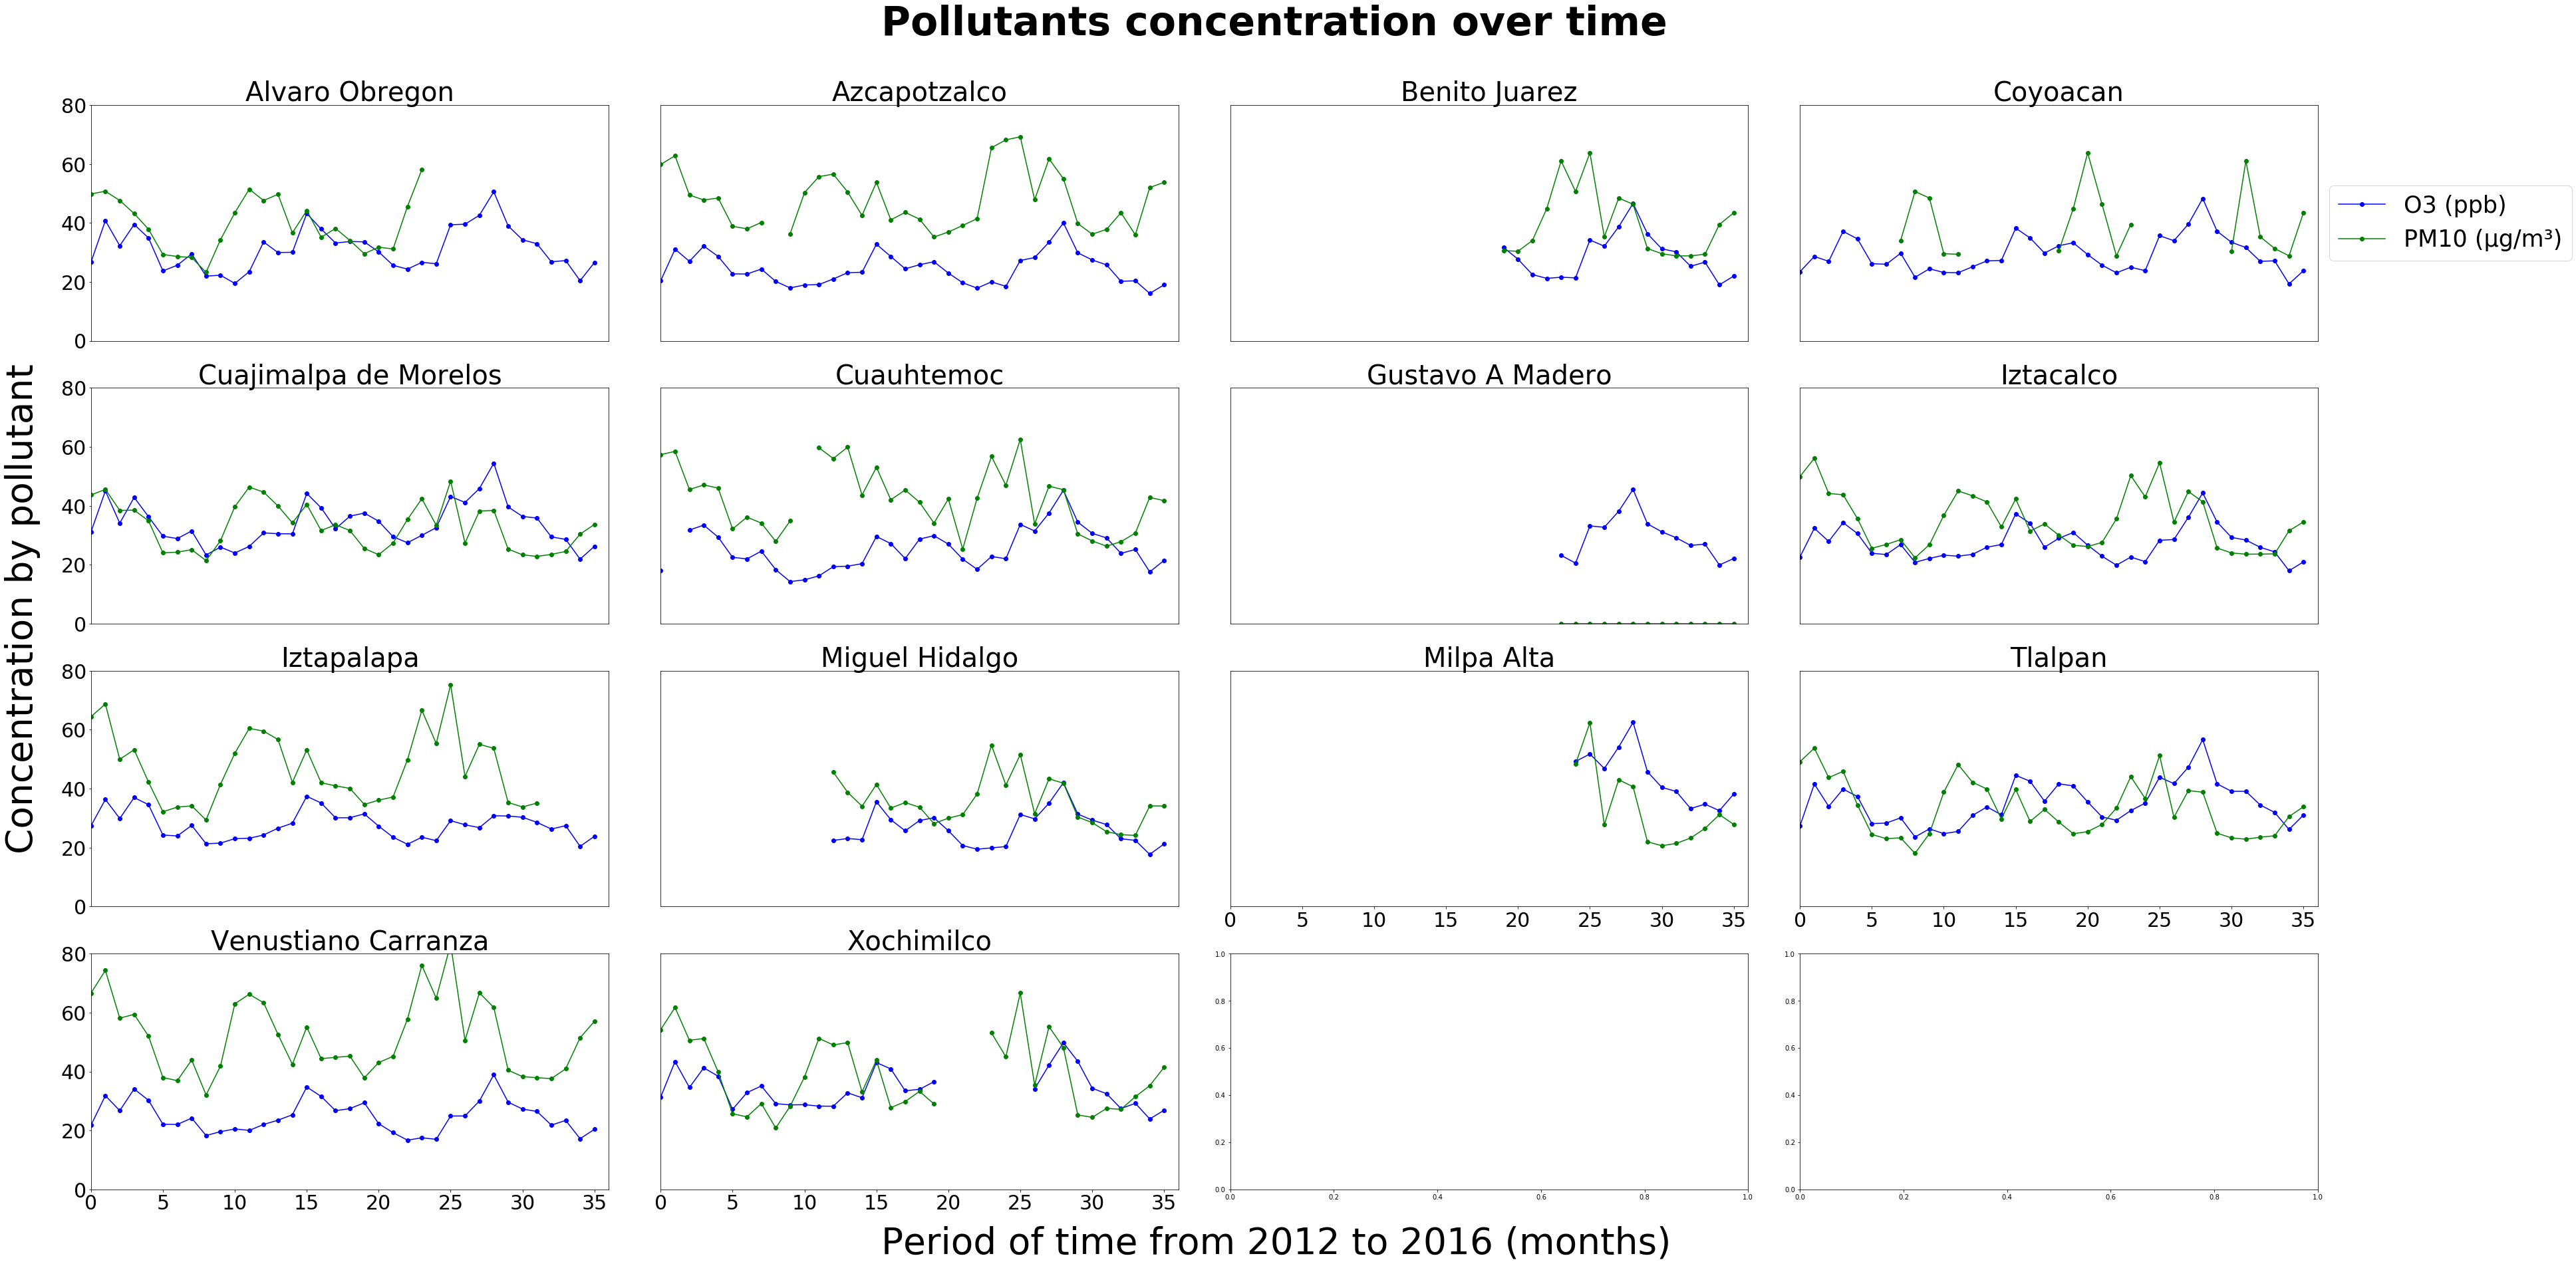

In [27]:
#Plot the average pollutant parameters by month per municipality

fig, axes = plt.subplots(nrows = 4, ncols = 4,  figsize = (60,30))
colors= ["blue", "green"]
selected_units=['ppb', 'µg/m³']
leg=0
plt.subplots_adjust(wspace=.1, # wspace controls the width of space between subplots
                    hspace=0.2)
for ax, station in zip(axes.flat, stations):
    counter=0
    d = townships_parameters_month[station]
    d = pd.DataFrame(d).reset_index()
    
    for i in range(len(colors)):        
        ax.plot( d.index, d.loc[:,selected_parameters[counter]].values, color=colors[counter],\
                label = f"{selected_parameters[counter]} ({selected_units[counter]})", marker="o")

        counter += 1
    ax.axis([0,number_of_years*12 , 0, 80])
    

    ax.tick_params('y', colors='black', labelsize=30)
    ax.tick_params('x', colors='black', labelsize=30)
    ax.xaxis.set_visible(True)
    #ax.title.set_text(station)
    ax.set_title(station , size=40)
    ax.yaxis.set_visible(False)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=35)
    
    if leg != 3:
        ax.get_legend().remove()
        
    if leg < 10:
        ax.xaxis.set_visible(False)
        
    if leg == 0:  
        ax.yaxis.set_visible(True)
    if leg == 4:  
        ax.yaxis.set_visible(True)
    if leg == 8:  
        ax.yaxis.set_visible(True)
    if leg == 12:  
        ax.yaxis.set_visible(True)
        
    leg=leg+1
    
fig.text(0.4, .95, "Pollutants concentration over time",
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=60, fontweight='bold')

fig.text(0.095, .7, "Concentration by pollutant",
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=55, rotation="vertical")

fig.text(0.4, .1, "Period of time from 2012 to 2016 (months)",
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=55)

plt.savefig("./images/Township_by_2014-2016_O3_pm10.png")
plt.show()

In [28]:
#To run the following sections it is necessary to select only one year not a set of years
#Create the data frame to look for the most polluted municipalities in a specific year or a range of years.
townships_parameters_year = {}

for station in stations:
    initialize_parameters_df = pd.DataFrame(columns=['Date',  'O3', 'PM10'])
    d = stations_pivot_year[station]
    
    for parameter in selected_parameters:
        if parameter in d:
            exist = True
        else:
            exist = False
            
        if exist == True:
            if parameter == 'CO':
                initialize_parameters_df.loc[:,parameter] = (d.loc[:,parameter])
            else:
                initialize_parameters_df.loc[:,parameter] = d.loc[:,parameter]
        if exist == False:
                length = len(initialize_parameters_df.loc[:,parameter])
                if length == 0: 
                    initialize_parameters_df.loc[:,parameter] = np.empty(number_of_years)
                else:
                    initialize_parameters_df.loc[:,parameter] = np.empty(length)
        
    townships_parameters_year[station] = initialize_parameters_df

In [59]:
#Remove Gustavo A. Madero from the analysis because there is no relevant data about this municipality
index = ["Alvaro Obregon", "Azcapotzalco", "Benito Juarez", "Coyoacan",\
"Cuajimalpa de Morelos", "Cuauhtemoc", "Iztacalco", "Iztapalapa", \
"Miguel Hidalgo", "Milpa Alta", "Tlalpan", "Venustiano Carranza", "Xochimilco"]

#Select the variables for ploting
o3 = []
pm10 = []

for station in index:
    o3.append(townships_parameters_year[station].loc[:,'O3'])
    pm10.append(townships_parameters_year[station].loc[:,'PM10'])

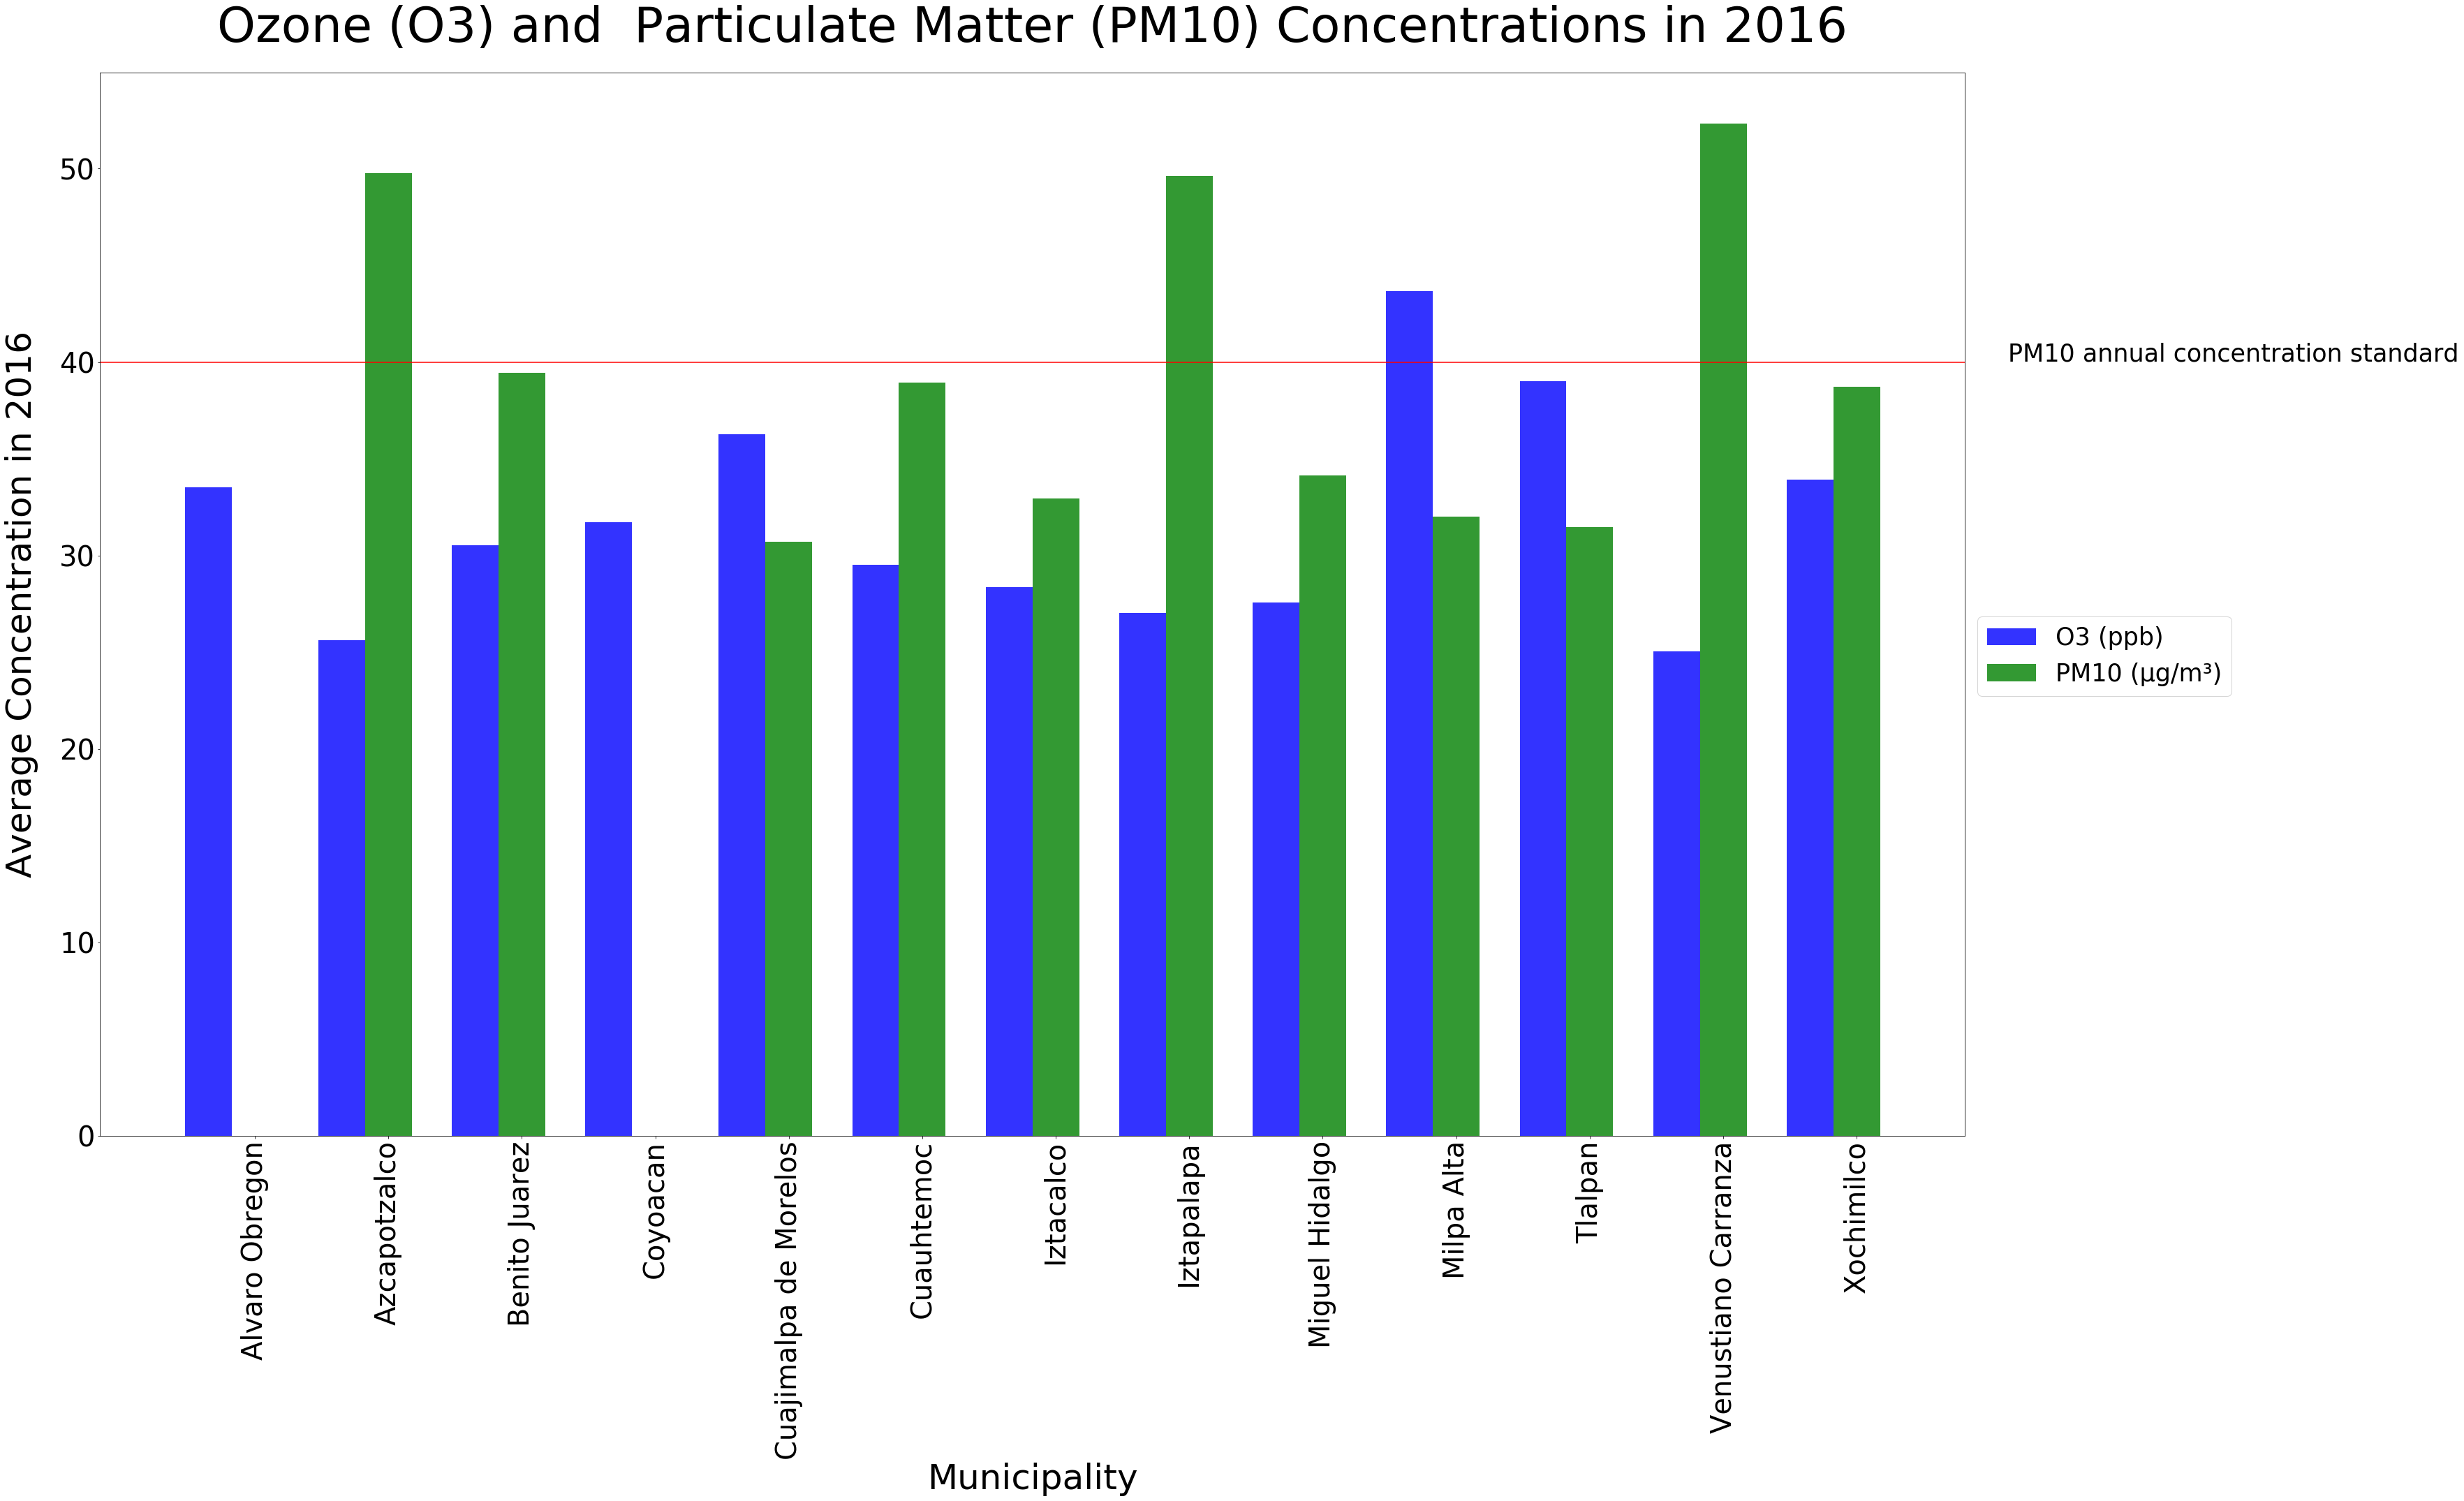

In [61]:
#Create a Bar chart with two parameters ozone and particle matter
# data to plot
n_groups = 13

O3 = o3 
PM10 = pm10

ind = np.arange(n_groups) 
# create plot
fig, ax = plt.subplots(figsize = (40,30))
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(ind, O3, bar_width, alpha=opacity, color='b',label='O3 (ppb)')
 
rects2 = plt.bar(ind + bar_width, PM10, bar_width, alpha=opacity, color='g', label='PM10 (µg/m³)')
 
plt.xlabel('Municipality', fontsize=50)
plt.ylabel('Average Concentration in 2016', fontsize=50, labelpad=30)
plt.title('Ozone (O3) and  Particulate Matter (PM10) Concentrations in 2016', fontsize =70,  y=1.025)
plt.xticks(ind + bar_width, index,rotation="vertical", fontsize = 40)
plt.yticks(fontsize = 40 )
plt.legend(bbox_to_anchor=(1, 0.5), fontsize=35, loc="best")
plt.tight_layout()
plt.axhline(y=40, color="r")
fig.text(1, .77, "PM10 annual concentration standard",
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=35, rotation="horizontal")

plt.savefig("./images/Concentration in 2016.png", bbox_inches = 'tight')

plt.show()

# Extra- backup analysis 
Extra analysis to compare air quality vs. respiratory diseases.
This is not part of the principal conclusions just extra techniques considered to refine the data and make general observations

In [184]:
data_file_asma = "../Resources/urgencias_asma-inf_por_delegacion.csv"
asma_Data = pd.read_csv(data_file_asma, encoding="ISO-8859-1")
asma_Data.head()

,Unnamed: 0,date,Cases/100k_ÃLVARO OBREGÃN,ASMA/100k_ÃLVARO OBREGÃN,Cases/100k_AZCAPOTZALCO,ASMA/100k_AZCAPOTZALCO,Cases/100k_BENITO JUÃREZ,ASMA/100k_BENITO JUÃREZ,Cases/100k_COYOACÃN,ASMA/100k_COYOACÃN,...,Cases/100k_TLÃHUAC,ASMA/100k_TLÃHUAC,Cases/100k_TLALPAN,ASMA/100k_TLALPAN,Cases/100k_VENUSTIANO CARRANZA,ASMA/100k_VENUSTIANO CARRANZA,Cases/100k_XOCHIMILCO,ASMA/100k_XOCHIMILCO,Cases/100k_TOTAL,ASMA/100k_TOTAL
0,0,2011-12-26,0.800019,NaN,8.746480,0.073814,2.395692,NaN,2.958196,NaN,...,8.849729,0.081687,5.464449,NaN,10.298107,0.069132,3.125503,NaN,5.124092,0.003312
1,1,2011-12-27,2.666731,NaN,9.246278,0.036907,1.437415,NaN,2.465163,0.048543,...,5.254526,0.040844,6.498263,NaN,9.361915,NaN,5.770160,NaN,5.101667,0.001656
2,2,2011-12-28,1.866711,0.039384,7.996781,0.036907,0.958277,NaN,2.136475,0.024272,...,4.424864,NaN,6.350575,NaN,9.830011,0.034566,2.644657,NaN,5.000755,0.001656
3,3,2011-12-29,0.400010,NaN,8.996379,0.073814,0.718707,NaN,3.615573,0.024272,...,4.701418,0.040844,5.464449,NaN,11.234298,0.034566,NaN,NaN,4.664381,0.003312
4,4,2011-12-30,0.400010,NaN,12.494971,0.036907,0.479138,NaN,3.122540,0.048543,...,4.424864,0.081687,4.578322,0.043623,7.489532,NaN,NaN,NaN,4.350433,0.001656


In [186]:
#The date without hours is split using slash to get the day, month and year
day= asma_Data.date.str.split('-').str[2].tolist()
month= asma_Data.date.str.split('-').str[1].tolist()
year = asma_Data.date.str.split('-').str[0].tolist()

asma_Data["day"] = day
asma_Data["month"] = month
asma_Data["year"] = year

#Another column is created joining the month and year to pivot by month
asma_Data["month_and_year"] = asma_Data['month'].astype(str) + " "+asma_Data['year'] #Month
asma_Data["date_woh"] = asma_Data['month'].astype(str) +" "+ asma_Data['day']
asma_Data["date_woh"] = asma_Data['date_woh'].astype(str) +" "+ asma_Data['year'] #day
asma_Data.set_index(asma_Data['date_woh'], inplace=True)
asma_Data.head()

,Unnamed: 0,date,Cases/100k_ÃLVARO OBREGÃN,ASMA/100k_ÃLVARO OBREGÃN,Cases/100k_AZCAPOTZALCO,ASMA/100k_AZCAPOTZALCO,Cases/100k_BENITO JUÃREZ,ASMA/100k_BENITO JUÃREZ,Cases/100k_COYOACÃN,ASMA/100k_COYOACÃN,...,ASMA/100k_VENUSTIANO CARRANZA,Cases/100k_XOCHIMILCO,ASMA/100k_XOCHIMILCO,Cases/100k_TOTAL,ASMA/100k_TOTAL,day,month,year,month_and_year,date_woh
date_woh,,,,,,,,,,,,,,,,,,,,,
12 26 2011,0,2011-12-26,0.800019,NaN,8.746480,0.073814,2.395692,NaN,2.958196,NaN,...,0.069132,3.125503,NaN,5.124092,0.003312,26,12,2011,12 2011,12 26 2011
12 27 2011,1,2011-12-27,2.666731,NaN,9.246278,0.036907,1.437415,NaN,2.465163,0.048543,...,NaN,5.770160,NaN,5.101667,0.001656,27,12,2011,12 2011,12 27 2011
12 28 2011,2,2011-12-28,1.866711,0.039384,7.996781,0.036907,0.958277,NaN,2.136475,0.024272,...,0.034566,2.644657,NaN,5.000755,0.001656,28,12,2011,12 2011,12 28 2011
12 29 2011,3,2011-12-29,0.400010,NaN,8.996379,0.073814,0.718707,NaN,3.615573,0.024272,...,0.034566,NaN,NaN,4.664381,0.003312,29,12,2011,12 2011,12 29 2011
12 30 2011,4,2011-12-30,0.400010,NaN,12.494971,0.036907,0.479138,NaN,3.122540,0.048543,...,NaN,NaN,NaN,4.350433,0.001656,30,12,2011,12 2011,12 30 2011


In [187]:
day_index = []
month_plot=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
year_plot=["2014","2015", "2016"]

day1_plot=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12","13", "14", "15",\
          "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27","28", "29", "30"]

day2_plot=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12","13", "14", "15",\
          "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27","28", "29", "30", "31"]

day3_plot=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12","13", "14", "15",\
          "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27","28"]


for yp in year_plot:
    for m in month_plot:
        if (m == "04") or (m == "06") or (m == "09") or (m == "11"):
            for d in day1_plot:
                day_index.append(f"{m} {d} {yp}")
        if (m == "02"):
            for d in day3_plot:
                day_index.append(f"{m} {d} {yp}")
        if (m == "01") or (m == "03") or (m == "05") or (m == "07")or (m == "08") or (m == "10") or (m == "12"):
            for d in day2_plot:
                day_index.append(f"{m} {d} {yp}")

In [188]:
final_plot=pd.DataFrame(columns=[['D', "Date"]])
final_plot["Date"]=day_index
final_plot.set_index(final_plot["Date"], inplace=True)
final_plot.head()

merged_disease= pd.merge(final_plot, asma_Data,left_index=True, right_index=True, how="left")

merged_disease.head()

,D,Date,Unnamed: 0,date,Cases/100k_ÃLVARO OBREGÃN,ASMA/100k_ÃLVARO OBREGÃN,Cases/100k_AZCAPOTZALCO,ASMA/100k_AZCAPOTZALCO,Cases/100k_BENITO JUÃREZ,ASMA/100k_BENITO JUÃREZ,...,ASMA/100k_VENUSTIANO CARRANZA,Cases/100k_XOCHIMILCO,ASMA/100k_XOCHIMILCO,Cases/100k_TOTAL,ASMA/100k_TOTAL,day,month,year,month_and_year,date_woh
Date,,,,,,,,,,,,,,,,,,,,,
01 01 2014,NaN,01 01 2014,666,2014-01-01,1.066692,NaN,13.494568,0.110721,2.156122,NaN,...,NaN,0.961693,NaN,4.316795,0.001656,01,01,2014,01 2014,01 01 2014
01 02 2014,NaN,01 02 2014,667,2014-01-02,2.000048,NaN,9.246278,0.036907,0.958277,NaN,...,NaN,NaN,NaN,4.328008,0.004968,02,01,2014,01 2014,01 02 2014
01 03 2014,NaN,01 03 2014,668,2014-01-03,1.066692,NaN,8.996379,0.073814,1.437415,NaN,...,0.069132,5.529737,0.106523,4.294370,0.004968,03,01,2014,01 2014,01 03 2014
01 04 2014,NaN,01 04 2014,669,2014-01-04,0.800019,NaN,11.495373,0.036907,1.676984,NaN,...,NaN,3.365927,NaN,4.305583,0.001656,04,01,2014,01 2014,01 04 2014
01 05 2014,NaN,01 05 2014,670,2014-01-05,0.933356,NaN,8.246681,0.110721,NaN,NaN,...,0.034566,5.048890,0.035508,4.047696,0.003312,05,01,2014,01 2014,01 05 2014


In [190]:
pollutants_index = ["Alvaro Obregon", "Azcapotzalco", "Benito Juarez", "Coyoacan",\
"Cuajimalpa de Morelos", "Cuauhtemoc", "Iztacalco", "Iztapalapa", \
"Miguel Hidalgo", "Milpa Alta", "Tlalpan", "Venustiano Carranza", "Xochimilco"]

cases = ['Cases/100k_ÃLVARO OBREGÃN',
        'Cases/100k_AZCAPOTZALCO',
       'Cases/100k_BENITO JUÃREZ',
       'Cases/100k_COYOACÃN',
        'Cases/100k_CUAJIMALPA DE MORELOS',
        'Cases/100k_CUAUHTÃMOC',
        'Cases/100k_IZTACALCO',
       'Cases/100k_IZTAPALAPA', 
       'Cases/100k_MIGUEL HIDALGO', 
       'Cases/100k_MILPA ALTA', 
       'Cases/100k_TLALPAN', 
       'Cases/100k_VENUSTIANO CARRANZA',
       'Cases/100k_XOCHIMILCO']

asma = ['ASMA/100k_ÃLVARO OBREGÃN',
       'ASMA/100k_AZCAPOTZALCO', 
       'ASMA/100k_BENITO JUÃREZ', 
       'ASMA/100k_COYOACÃN', 
       'ASMA/100k_CUAJIMALPA DE MORELOS', 
       'ASMA/100k_CUAUHTÃMOC', 
       'ASMA/100k_IZTACALCO', 'ASMA/100k_IZTAPALAPA',
       'Cases/100k_MIGUEL HIDALGO', 
       'ASMA/100k_MILPA ALTA', 
       'ASMA/100k_TLALPAN',
       'ASMA/100k_VENUSTIANO CARRANZA',
        'ASMA/100k_XOCHIMILCO']

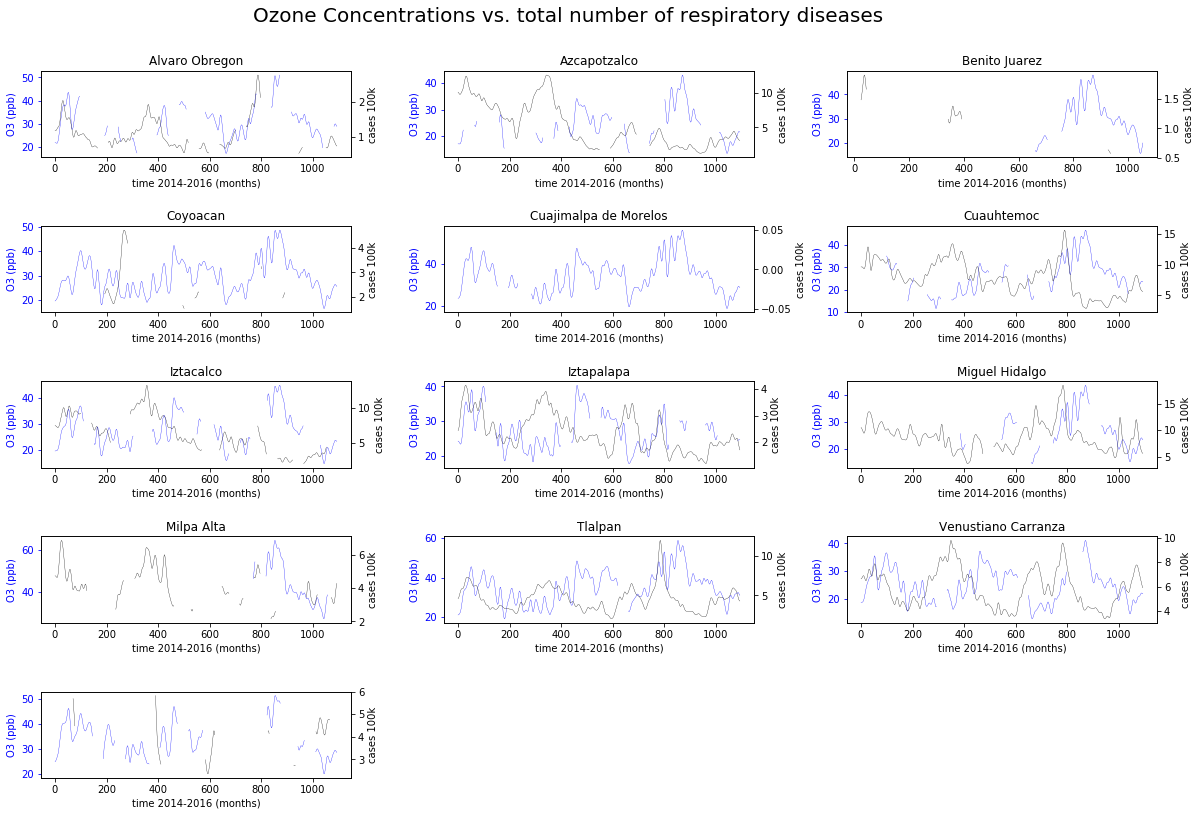

In [195]:
plt.figure(figsize=(20, 13))
plt.subplots_adjust(wspace=.3, # wspace controls the width of space between subplots
                    hspace=0.8) 

for i in range(len(pollutants_index)):
    d = townships_parameters_day[pollutants_index[i]]
    d=pd.merge(final_plot, d, left_index=True, right_index=True, how="left")
    d=pd.merge(d, merged_disease, left_index=True, right_index=True, how="left")
    d = pd.DataFrame(d).reset_index(drop=True)
    
    ax1 = plt.subplot(5,3,i+1) # subplot(2,1,1) is active, plotting will be done there
    ax1.plot( d.index, d.loc[:,'O3'].values, color="blue", label = 'O3 (ppb)', linewidth=0.3)
    ax1.set_xlabel('time 2014-2016 (months)')
            # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('O3 (ppb)', color='blue')
    ax1.tick_params('y', colors='blue')

    ax2 = ax1.twinx()
    ax2.plot( d.index, d.loc[:,cases[i]].values, color="black",label = "PM10 ('µg/m³')", linewidth=0.3)
    ax2.set_ylabel('cases 100k', color='black')
    ax2.tick_params('y', colors='black')

    fig.tight_layout()  
    plt.title(pollutants_index[i])


plt.title('Ozone Concentrations vs. total number of respiratory diseases', fontsize =20,  y=8.7, x=1.7)


plt.savefig("./images/o3_vs_cases_2014-2016.png", bbox_inches = 'tight')
plt.show()

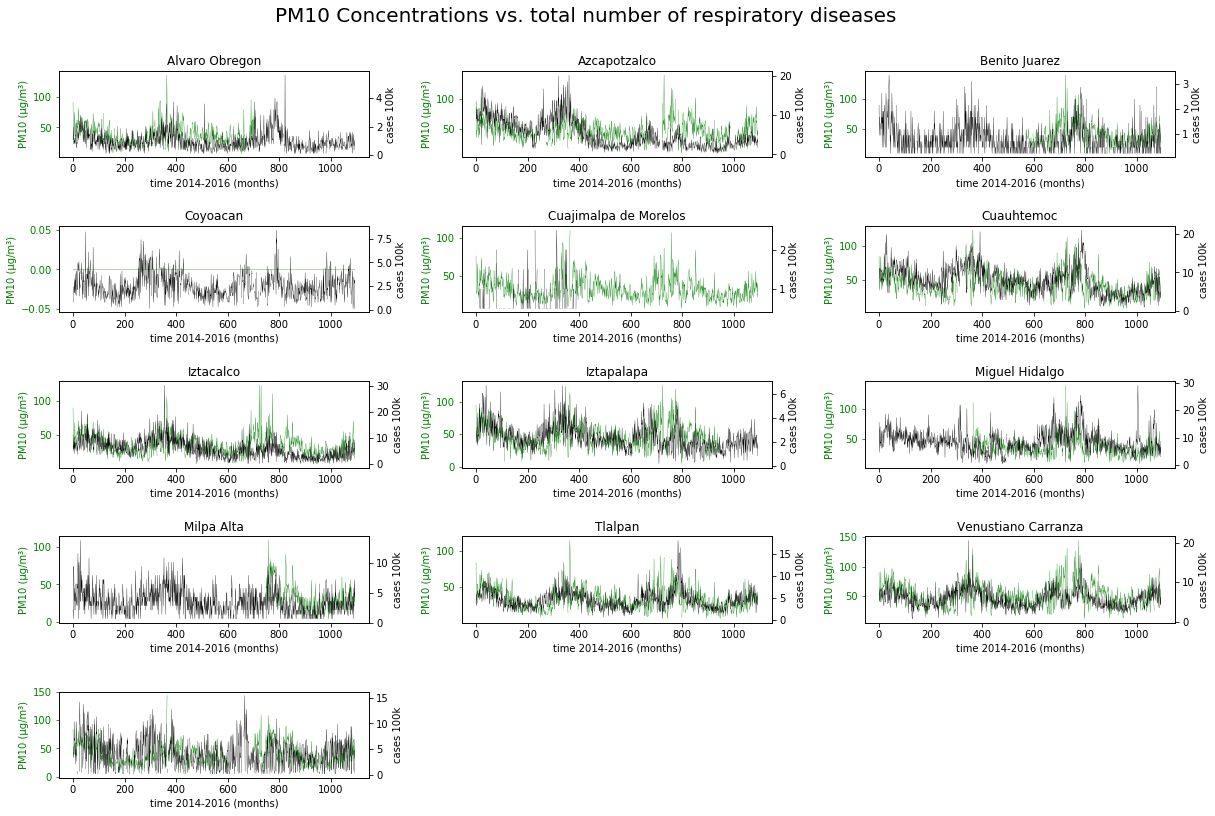

In [192]:
plt.figure(figsize=(20, 13))
plt.subplots_adjust(wspace=.3, # wspace controls the width of space between subplots
                    hspace=0.8) 

for i in range(len(pollutants_index)):
    d = townships_parameters_day[pollutants_index[i]]
    d=pd.merge(final_plot, d, left_index=True, right_index=True, how="left")
    d=pd.merge(d, merged_disease, left_index=True, right_index=True, how="left")
    d = pd.DataFrame(d).reset_index(drop=True)
    
    d.to_csv(f"./Health/{pollutants_index[i]}data_14_16.csv", encoding="ISO-8859-1", index=False, header=True) 
    
    ax1 = plt.subplot(5,3,i+1) # subplot(2,1,1) is active, plotting will be done there
    ax1.plot( d.index, d.loc[:,'PM10'].values, color="green", label = 'O3 (ppb)', linewidth=0.3)
    ax1.set_xlabel('time 2014-2016 (months)')
            # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('PM10 (µg/m³)', color='green')
    ax1.tick_params('y', colors='green')

    ax2 = ax1.twinx()
    ax2.plot( d.index, d.loc[:,cases[i]].values, color="black",label = "PM10 ('µg/m³')", linewidth=0.3)
    ax2.set_ylabel('cases 100k', color='black')
    ax2.tick_params('y', colors='black')

    fig.tight_layout()  
    plt.title(pollutants_index[i])


plt.title('PM10 Concentrations vs. total number of respiratory diseases', fontsize =20,  y=8.7, x=1.7)


plt.savefig("./images/pm10_vs_cases_2014-2016.png", bbox_inches = 'tight')
plt.show()

In [185]:
data_file = "../Resources/book4.csv"
d = pd.read_csv(data_file, encoding="ISO-8859-1")
d.head()

,Date_x,Cases/100k_VENUSTIANO CARRANZA,PM10,Date_x.1,Cases/100k_VENUSTIANO CARRANZA_GF,cases2,PM10_fg,PM10_sd,pm_1,pm_2,pm_3,pm_4,cases_wo,PM10_wo,cases_wo_original,PM10_wo_original
0,01 01 2015,9.361915,96.181818,01 01 2015,7.766411,-1.308866,43.472464,-29.176999,7.845663,42.314386,8.065865,47.004882,8.065865,47.004882,9.361915,96.181818
1,01 02 2015,9.127867,40.695652,01 02 2015,8.905077,-0.093455,49.787975,5.493838,8.244912,46.707761,8.107800,52.489398,8.107800,52.489398,9.127867,40.695652
2,01 03 2015,10.298107,29.086957,01 03 2015,8.734878,-2.507004,26.926488,62.498175,8.107021,51.992500,7.953178,59.679898,7.953178,59.679898,10.298107,29.086957
3,01 04 2015,8.425724,48.708333,01 04 2015,8.471223,3.701631,9.558837,-46.837175,7.971467,58.767934,7.981210,66.085522,7.981210,66.085522,8.425724,48.708333
4,01 05 2015,7.489532,41.333333,01 05 2015,5.700564,1.147443,54.689363,7.506800,7.781046,68.279261,8.123585,71.490969,8.123585,71.490969,7.489532,41.333333


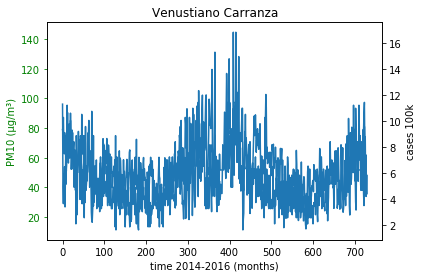

In [186]:
ax1 = plt.subplot() # subplot(2,1,1) is active, plotting will be done there
ax1.plot(d.index, d.loc[:,"PM10_wo_original"])
ax1.set_xlabel('time 2014-2016 (months)')
            # Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('PM10 (µg/m³)', color='green')
ax1.tick_params('y', colors='green')

ax2 = ax1.twinx()
ax2.plot(d.index, d.loc[:,"cases_wo_original"])
ax2.set_ylabel('cases 100k', color='black')
ax2.tick_params('y', colors='black')

#fig.tight_layout()  
plt.title("Venustiano Carranza")
plt.show()

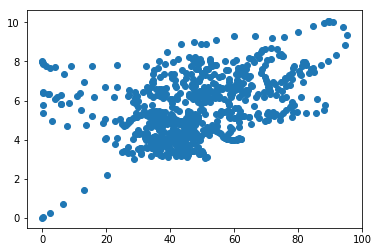

In [187]:
plt.scatter(d.loc[:,"PM10_wo"],d.loc[:,"cases_wo"])
plt.show()

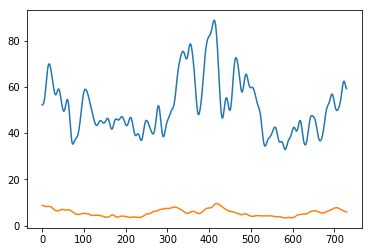

In [195]:
#Use gaussian filtering 1D to smooth the signal
from scipy.ndimage import gaussian_filter1d
x= gaussian_filter1d(d.loc[:,"PM10_wo_original"], 5)
y= gaussian_filter1d(d.loc[:,"cases_wo_original"], 5)
plt.plot(d.index, x)
plt.plot(d.index, y)
plt.show()

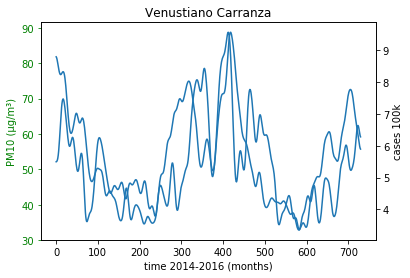

In [196]:

ax1 = plt.subplot() # subplot(2,1,1) is active, plotting will be done there
ax1.plot(d.index, x)
ax1.set_xlabel('time 2014-2016 (months)')
            # Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('PM10 (µg/m³)', color='green')
ax1.tick_params('y', colors='green')

ax2 = ax1.twinx()
ax2.plot(d.index, y)
ax2.set_ylabel('cases 100k', color='black')
ax2.tick_params('y', colors='black')

#fig.tight_layout()  
plt.title("Venustiano Carranza")
plt.show()

In [197]:
from scipy import stats
stats.pearsonr(x, y)

(0.55365587189221277, 7.2297729183194459e-60)

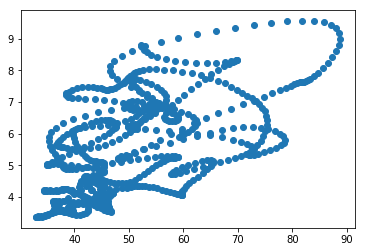

In [198]:
plt.scatter(x,y)
plt.show()